## Using Python to automate investment strategy and to automate back testing on the S&P 500

# Getting companies currently listed in the S&P 500 using Wikipedia as source 

In [13]:
import bs4 as bs 
import requests 

# scraping Wikipedia page for the S&P
page = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(page.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = []

for row in table.findAll('tr')[1:]:
  ticker = row.findAll('td')[0].text.replace('\n','')
  ticker = ticker.split(':\xa0')
  if len(ticker) > 1:
    tickers.append(ticker[1])
  else:
    tickers.append(ticker[0])

In [15]:
# Confirm we have 505 coomon stocks issued by 500 companies in the Index 
print(len(tickers))

505


# Creating 3 functions to test our strategy

1. Volatility function - Here we are not going to take into account the weights of the stocks in our portfolio, instead we take volatility to mean that of a single stock but we take into account the portfolio's performance. The formula is: 

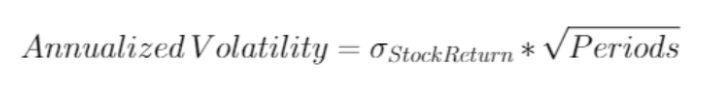

2. Compound Annual Growth Rate (CAGR) - This allows us to obtain the annual performance of an asset/portfolio by obatining it's current market value from its initial value. CAGR assumes that earnings are reinvested at the end of each year and it allows to comparison between different strategies. The formula is: 

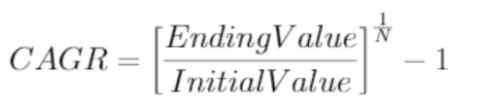

3. Sharpe Ratio - This allows us to analyze returns for each assumed unit risk within the portfolio. The ris-free rate is used to isolate the returns associated with our investment plan. We employ a combination of the volatility and CAGR to calculate performance and portfolio. The formula is given below: 

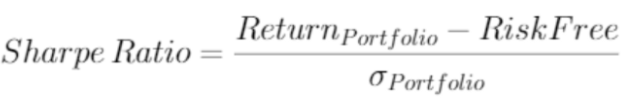

In [32]:
# Volatility function
from math import sqrt 
def volatility(stock_data):
  '''
  Calculate the mean annual volatility of a given stratgey 
  '''
  volatility = stock_data['Return'].std() * sqrt(52)

  return volatility

In [17]:
#  CAGR 
def CAGR(stock_data):
  """
  Calculate CAGR 
  """
  stock_data['Cumulative_Return'] = (1 + stock_data['Return']).cumprod()
  years = len(stock_data)/52
  carg = stock_data['Cumulative_Return'].tolist()[-1] ** (1/years) - 1

  return carg 

In [18]:
# Sharpe Ratio

def sharpe_ratio(stock_data, risk_free):
  """
  calculate sharpe ratio of a given portfolio
  """
  sharpe = (CAGR(stock_data) - risk_free) / volatility(stock_data)

  return sharpe 

In [21]:
pip install yfinance --upgrade --no-cache-dir

     |████████████████████████████████| 6.3 MB 36.1 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=9f64135c281e9a14b72d2f9ae3739652ad77fe0d65c58472348fa4029b6a24fe
  Stored in directory: /tmp/pip-ephem-wheel-cache-6ib1b5a2/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


# Using our obtained tickers to download historical price of each company in the index. We obtain weekly prices from January 1, 2015 to December 30, 2020.

In [25]:
import datetime as dt 
import pandas_datareader as web 
import pandas as pd 
import yfinance as yf 

start = dt.datetime(2015, 1, 1)
end = dt. datetime(2020, 12, 30)
sp_500 = {}

for stock in tickers:
  print(f'Downloading data for {stock}')
  sp_500[stock] = yf.download(stock, start, end, interval = '1wk')
  print(f'{stock} downloaded...')

sp_500_returns = pd.DataFrame()

for stock in tickers:
  print(f'calculating weekly return for {stock}')
  sp_500_returns[stock] = sp_500[stock]['Adj Close'].pct_change().dropna()

[*********************100%***********************]  1 of 1 completed
MMM downloaded...
[*********************100%***********************]  1 of 1 completed
ABT downloaded...
[*********************100%***********************]  1 of 1 completed
ABBV downloaded...
[*********************100%***********************]  1 of 1 completed
ABMD downloaded...
[*********************100%***********************]  1 of 1 completed
ACN downloaded...
[*********************100%***********************]  1 of 1 completed
ATVI downloaded...
[*********************100%***********************]  1 of 1 completed
ADBE downloaded...
[*********************100%***********************]  1 of 1 completed
AMD downloaded...
[*********************100%***********************]  1 of 1 completed
AAP downloaded...
[*********************100%***********************]  1 of 1 completed
AES downloaded...
[*********************100%***********************]  1 of 1 completed
AFL downloaded...
[*********************100%*************

In [26]:
sp_500_returns.head()

,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AFL,A,APD,AKAM,ALK,ALB,ARE,ALGN,ALLE,LNT,ALL,GOOGL,GOOG,MO,AMZN,AMCR,AEE,AAL,AEP,AXP,AIG,AMT,AWK,AMP,ABC,AME,AMGN,APH,ADI,ANSS,...,UNM,VLO,VTR,VRSN,VRSK,VZ,VRTX,VFC,VIAC,VTRS,V,VNO,VMC,WRB,WAB,WMT,WBA,DIS,WM,WAT,WEC,WFC,WELL,WST,WDC,WU,WRK,WY,WHR,WMB,WLTW,WYNN,XEL,XLNX,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-08,0.000250,-0.010724,-0.048259,0.026019,0.002824,-0.006820,-0.015750,0.019380,-0.055660,0.008443,-0.029838,-0.013712,-0.016309,-0.007480,0.031339,0.045311,0.024522,0.025013,-0.004856,0.024039,-0.005444,0.001544,-0.000459,0.037089,-0.017258,0.000000,0.006174,-0.067912,0.021484,-0.032932,-0.056901,-0.017576,0.023734,-0.013031,0.001305,-0.022107,-0.019464,-0.008132,-0.005575,0.012671,...,-0.040325,-0.051786,0.015437,0.011323,0.000159,0.028917,-0.002321,0.005568,0.025607,-0.027090,-0.020655,0.012095,0.023108,-0.024940,-0.019562,-0.022461,-0.021018,0.015081,0.009745,-0.013198,0.019314,-0.021947,0.027088,0.004866,0.005826,-0.016515,NaN,0.007186,0.035803,-0.025346,-0.014113,0.021587,0.007181,-0.019668,-0.036892,-0.000276,0.045162,-0.012639,-0.062405,-0.011032
2015-01-15,0.016892,0.000299,-0.008309,-0.011503,-0.004956,0.061807,0.022146,-0.068441,0.016708,0.004566,0.009557,-0.023041,0.022654,0.009379,0.055899,-0.015289,0.011809,-0.084507,-0.043557,0.028022,0.012531,0.028581,0.034280,0.049101,0.013571,NaN,0.018190,0.086217,0.021989,0.006891,-0.010705,-0.005244,0.024452,0.010963,0.007384,0.001019,0.014308,0.028217,0.019996,0.027626,...,-0.007212,0.051939,0.009276,0.001777,0.007305,0.027251,0.039126,-0.032005,0.031577,0.000000,0.006730,-0.003770,0.003544,0.004911,0.010337,0.000346,0.008001,-0.000637,0.017757,-0.001136,0.038447,0.016585,0.006471,-0.012202,-0.019675,-0.006369,NaN,-0.021131,-0.005484,0.029858,-0.020223,-0.038425,0.030436,0.003384,0.018572,-0.005587,0.018466,-0.011094,-0.013715,0.028352
2015-01-22,0.008613,-0.014753,-0.013557,0.320815,-0.045053,0.028358,-0.018032,0.073469,0.038800,-0.066667,-0.012737,-0.004193,-0.029839,-0.021238,0.057248,-0.055281,0.031159,0.047764,0.027021,-0.012416,0.000284,-0.015296,-0.015520,-0.004791,0.022405,-0.069030,-0.018511,-0.056829,-0.011849,-0.067754,-0.031871,0.022015,0.001945,0.000396,0.038693,-0.008139,-0.017410,0.000742,-0.030231,-0.016275,...,-0.019267,0.091545,0.033559,-0.036722,0.009144,-0.045596,-0.030618,-0.009068,0.001780,0.011907,-0.042444,0.005960,0.030155,0.010181,0.010707,0.002078,-0.024077,-0.015929,-0.001707,0.040956,0.006023,0.001152,0.007400,-0.021215,-0.063772,-0.011655,NaN,-0.002803,0.018972,-0.006079,-0.006494,0.074113,-0.003459,-0.066008,-0.023931,0.019581,0.017527,-0.011909,-0.023722,-0.023930
2015-01-29,0.005307,0.040544,-0.079871,0.084301,0.035325,0.041122,0.028897,0.083650,-0.017765,0.016234,0.057880,0.029211,0.069077,0.016274,-0.029112,-0.117753,-0.027893,-0.072904,0.023551,-0.007959,0.032139,0.026677,0.025020,0.000370,0.200191,0.000000,-0.022369,-0.022916,-0.018303,0.023003,0.046738,-0.010417,-0.018176,0.043437,-0.005188,0.015590,-0.020628,0.011117,0.016059,0.011397,...,0.048914,0.053970,-0.026997,0.047514,0.027183,0.038002,-0.098878,-0.030269,0.007994,-0.036568,0.075215,-0.013265,0.020563,-0.024390,0.005179,-0.001958,0.012200,0.092910,-0.007979,0.001513,-0.026061,0.016680,-0.027938,0.006224,0.042171,0.043043,NaN,-0.007872,0.066878,0.067043,0.047619,-0.048019,-0.006676,0.027599,0.018389,0.010288,0.027560,0.008908,0.039799,0.008119
2015-02-05,-0.002002,-0.005313,-0.003866,0.087719,0.007099,0.052974,0.010100,0.077193,0.037834,-0.039403,0.018952,0.005625,0.010713,0.063386,-0.032834,0.088639,-0.014139,0.027624,0.019594,-0.050654,-0.019289,0.022619,0.025270,0.013511,0.028485,0.026052,-0.047106,-0.037808,-0.063324,0.028705,0.014366,-0.019315,-0.037743,0.033060,0.029936,0.007877,0.010961,0.017958,0.034214,0.032837,...,0.050000,0.019709,-0.026473,0.072082,0.010798,0.042050,-0.005949,0.017276,0.000176,0.010146,0.004152,0.015516,0.091367,0.032024,0.0

## Choosing our portfolio strategy:

1. We take into account how may X stocks will make up the portfolio and how may Y to remove from the portfolio each week
2. On a weekly basis, we review which are the X best stocks with the highest return and the Y worst performing stocks within the portfolio
3. The we eliminate the weak-performing Y stocks from the portfolio and replace them with the best X stocks in the SP 500
4. This process is repeated on a weekly

In [28]:
import numpy as np

def portfolio(df, n_stocks, n_remove):
  '''
  df: dataframe with the stocks returns 
  n_stocks: number of stocks to be selected in the portfolio 
  n_remove: number of bad stocks to remove in the portfolio  
  '''

  portfolio = []
  weekly_return = [0]
  for i in range(1, len(df)):
    if len(portfolio) > 0:
      weekly_return.append(df[portfolio].iloc[i, :].mean())
      negative_stocks = df[portfolio].iloc[i, :].sort_values(ascending=True)[: n_remove].index.tolist()
      portfolio = [stock for stock in portfolio if stock not in negative_stocks]
    to_fill = n_stocks - len(portfolio)
    new_stocks = df.iloc[i, :].sort_values(ascending=False)[:n_stocks].index.tolist()
    new_stocks = [stock for stock in new_stocks if stock not in portfolio][:to_fill] # we make sure to not repeat stocks in the portfolio
    portfolio = portfolio + new_stocks 
    print(f'The weekly portfolio selected is {portfolio}')

  portfolio_return = pd.DataFrame(np.array(weekly_return), columns=['Return'])
  return portfolio_return


In [29]:
sp500 = portfolio(sp_500_returns, 5, 1)

The weekly portfolio selected is ['NFLX', 'NEM', 'PSX', 'LYB', 'PAYC']
The weekly portfolio selected is ['NFLX', 'NEM', 'PSX', 'PAYC', 'ABMD']
The weekly portfolio selected is ['NFLX', 'NEM', 'PSX', 'ABMD', 'AMZN']
The weekly portfolio selected is ['NFLX', 'PSX', 'ABMD', 'AMZN', 'MLM']
The weekly portfolio selected is ['PSX', 'ABMD', 'AMZN', 'MLM', 'WYNN']
The weekly portfolio selected is ['PSX', 'ABMD', 'MLM', 'WYNN', 'FCX']
The weekly portfolio selected is ['PSX', 'ABMD', 'MLM', 'FCX', 'BKNG']
The weekly portfolio selected is ['PSX', 'ABMD', 'MLM', 'BKNG', 'NXPI']
The weekly portfolio selected is ['ABMD', 'MLM', 'BKNG', 'NXPI', 'CZR']
The weekly portfolio selected is ['ABMD', 'MLM', 'BKNG', 'NXPI', 'MGM']
The weekly portfolio selected is ['ABMD', 'MLM', 'BKNG', 'MGM', 'DRI']
The weekly portfolio selected is ['ABMD', 'MLM', 'BKNG', 'DRI', 'LHX']
The weekly portfolio selected is ['ABMD', 'BKNG', 'DRI', 'LHX', 'PRGO']
The weekly portfolio selected is ['BKNG', 'DRI', 'LHX', 'PRGO', 'CZR'

## Strategy vs SP500 Index 

## Given our portfolio strategy above, we will analyze its performance using our previous three strategies. We compare this to an approximate of 2% for the three month treasury bill rate as a risk-free rate. 

In [33]:
print(f'The Compound Annual Growth Rate is {CAGR(sp500_portfolio)}')
print(f'The Portfolio Volatility is {volatility(sp500_portfolio)}')
print(f'The Sharpe Ratio is {sharpe_ratio(sp500_portfolio, 0.02)}')

The Compound Annual Growth Rate is 0.25954531298378924
The Portfolio Volatility is 0.28622406487679486
The Sharpe Ratio is 0.8369153484243246


# As a point of comparison, we use the returns of the SP 500 to see its volatility and performance over the same period.

In [35]:
"""
Calculating KPI for the SP500 Index over the same period 
"""
sp500_index = yf.download('SPY', start, end, interval = '1wk')
sp500_index['Return'] = sp500_index['Adj Close'].pct_change()
sp500_index.dropna(inplace = True)

print(f'The Compound Annual Growth Rate is {CAGR(sp500_index)}')
print(f'The Index volatility is {volatility(sp500_index)}')
print(f'The Sharpe Ratio is {sharpe_ratio(sp500_index, 0.02)}')


[*********************100%***********************]  1 of 1 completed
The Compound Annual Growth Rate is 0.12837005034653592
The Index volatility is 0.15976592080822588
The Sharpe Ratio is 0.6783051717056562


## Result of the tests performed on the portfolio strategy and the SP 500 index shows that although the portfolio volatility is higher, the CAGR and the Sharpe Ratio are higher in the strategy used. 

## Finally we graph the performance of both for comparison.

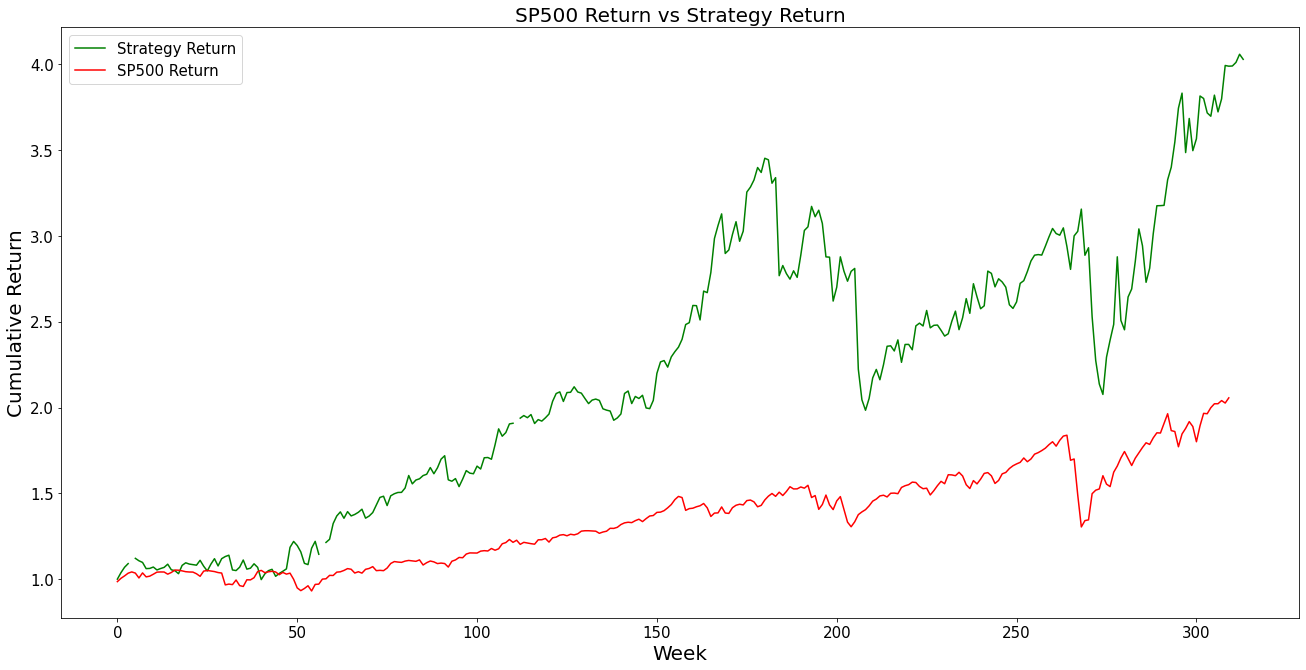

In [37]:
# Visualization 
# sp500_portfolio
# sp500_index 

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (20, 10))
plt.plot((1 + sp500_portfolio['Return']).cumprod(), color = 'g')
plt.plot((1 + sp500_index['Return'][2:].reset_index(drop = True)).cumprod(), color = 'r')
plt.title('SP500 Return vs Strategy Return', fontsize = 20)
plt.ylabel('Cumulative Return', fontsize = 20)
plt.xlabel('Week', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
ax.legend(['Strategy Return', 'SP500 Return'], fontsize = 15)
plt.subplots_adjust(top = 0.92, bottom = 0.1, left = 0.08, right = 0.94)
plt.show()

### The graph shows that although during the first 45 - 49 weeks, the returns of both look close, our investment strategy manages to have better returns than the SP 500 Index.

### Conclusion

### Immediate observations from the experiment reveals that:

### 1. The strategy allows us to obtain better returns than the benchmark index despite not using technical indicatiors

### 2. The backtesting allows us to incorporate the benefit of the strategy and expand on it as a future strategy 

### 3. We can expand on this strategy using daily returns and efficient frontier theory to identify the weight of specific share within our portfolio that maximizes the Sharpe ratio